In [1]:
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure', titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits

Populating the interactive namespace from numpy and matplotlib


In [5]:
def mkemccd(modeln,
            gain=5000.,
            dark=0.5,
            cic=0.01,
            readn=99,
            crrate=5.,
            HPrate=3.,
            frmt=100.,
            yrs=3,
            xs=450,
            ys=250,
            transpose=False,
            debug=False,
            verbose=False):
    ''' EMCCD noise generator based on Patrick's IDL code
    
    Parameters
    ----------
    modeln: string
        Link to the input FITS file
    gain: float
        Gain of the multiplying register
    dark: float
        dark current
    '''

    # whole array including overscan
#     xs = 2144
#     ys = 1137
#     xs = 450
#     ys = 250

    # size of image area
    data = fits.getdata(modeln)
    if transpose:
        data = data.T

    yi, xi = data.shape

    ##########################################################################################
    # Dark current
    ##########################################################################################
    if verbose:
        print("Dark current image")
    dkimg = np.zeros((yi, xi), dtype=np.float)
    ndark = np.round(dark/3600.*frmt*xi*yi).astype(int)
    if verbose: print('{:} dark counts per exposure'.format(ndark))
    x0 = np.random.randint(0, xi, ndark)
    y0 = np.random.randint(0, yi, ndark)
    dkimg[y0, x0] += 1

    ##########################################################################################
    # Clock-Induced Charge
    ##########################################################################################
    if verbose:
        print("CIC image")
    cicimg = np.zeros((ys, xs), dtype=np.float)
    ncic = np.round(cic*xs*ys).astype(int)
    if verbose: print('{:} CIC counts per exposure'.format(ncic))
    x0 = np.random.randint(0, xs, ncic)
    y0 = np.random.randint(0, ys, ncic)
    cicimg[y0, x0] += 1

    ##########################################################################################
    # Hot pixels
    ##########################################################################################
    if verbose:
        print("Hot pixels image")
    hpimg = np.zeros(xi*yi, dtype=np.float)
    if yrs != 0:
        hpmask = fits.getdata(
            '/Users/mrizzo/IFS/mkemccd_v6_171207/emccd_hot_pixel_map_%dyr.fits' % np.round(yrs))
        hpmask = np.reshape(hpmask[:yi, :xi], -1)
        hpidx = np.array(np.where(hpmask > 0)[0])
        hpidx = np.concatenate([hpidx, hpidx+1, hpidx+2, hpidx+3])
        hpidx[hpidx > len(hpmask)] = len(hpmask)
        nhpcnts = np.round(len(hpidx)*HPrate/3600.*frmt).astype(int)
        if verbose: print('{:} Hot pixel counts per exposure'.format(nhpcnts))
        
        idx1 = np.random.randint(0, len(hpidx), nhpcnts)
        hpimg[hpidx[idx1]] += 1

    hpimg = np.reshape(hpimg, (yi, xi))

    ##########################################################################################
    # Cosmic rays
    ##########################################################################################
    if verbose:
        print("Cosmic ray image")
    crimg = np.zeros(xs*ys, dtype=np.float)
    ncr = np.round(crrate*frmt*(xi*0.0013)*(yi*0.0013))
    if verbose: print('{:} cosmic rays per exposure'.format(ncr))
    if ncr > 1:
        toyx = np.arange(xs, dtype=np.float)
        ncrpx = np.round(0.0323*gain+133.5)
        ncrpxidx = np.where(toyx == ncrpx)[0][0]
        # Empirical toy model
        crtoy = 5e3*np.exp(-toyx/300.)+3e4*np.exp(-toyx/30.) + \
            1e4*np.exp(-toyx/15.)+3e5*np.exp(-toyx/5.)
        # Scale to photon counting threshold
        crtoy = crtoy/crtoy[ncrpxidx]*5.*readn
        # Saturate leading pixels
        crtoy[0:2] = 65536
        # This is not Pythonized yet; I'd have to think about it a bit, but it should be possible
        for i in range(ncr.astype(int)):
            crx = np.random.randint(0, xi)
            crx += xs-xi
            cry = np.random.randint(0, yi)
            cridx = cry*xs+crx
            if cridx > len(crimg)-1-xs:
                cridx = len(crimg)-1-xs
            crimg[cridx:cridx+xs] = crtoy

    crimg = np.reshape(crimg, (ys, xs))

    ##########################################################################################
    # Photon counts
    ##########################################################################################
    if verbose:
        print("Photon counts image")
    phimg = np.random.poisson(data*frmt)

    ##########################################################################################
    # Add components together
    ##########################################################################################
    imgsum = cicimg.copy()
    imgsum[:yi, xs-xi:xs] += dkimg+hpimg+phimg

    ##########################################################################################
    # Gain register
    ##########################################################################################
    if verbose:
        print("Gain image")

    gainimg = np.zeros((ys, xs), dtype=np.float)
    EMmask = imgsum > 0
    gainimg[EMmask] = np.random.gamma(
        imgsum[EMmask], gain)

    outimg = gainimg+crimg+np.random.normal(0.0, readn, (ys, xs))
    if debug:
        return outimg, gainimg, crimg, dkimg, hpimg, phimg
    else:
        return outimg

In [16]:
yrs=3
hpmask = fits.getdata('/Users/mrizzo/IFS/mkemccd_v6_171207/emccd_hot_pixel_map_%dyr.fits' % np.round(yrs))
np.prod(hpmask.shape)

1048576

In [23]:
xi = 1024
yi = 1024
hpidx = np.array(np.where(np.reshape(hpmask,-1)> 0)[0])
print np.reshape(hpmask,-1).shape
hpidx = np.concatenate([hpidx,hpidx+1,hpidx+2,hpidx+3])
print len(hpidx)

hpidx[hpidx>(xi-1)*(yi-1)] = (xi-1)*(yi-1)

idx1 = 10000#np.random.randint(np.prod(hpidx.shape))
print idx1,hpidx[idx1]

(1048576,)
62916
10000 661616


In [37]:
xs = 2133
gain=5000.
toyx = np.arange(xs,dtype=np.float)
ncrpx = np.round(0.0323*gain+133.5)
ncrpxidx = np.where(toyx == ncrpx)[0][0]
print ncrpxidx

295


In [40]:
a = np.arange(10)
b = np.reshape(a,(5,2))
print b

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]


In [46]:
pimg = np.reshape(fits.getdata('/Users/mrizzo/IFS/mkemccd_v6_171207/speckles_phot_per_second.fits'),-1)
pimgmin = np.amin(pimg[np.where(pimg>0)])
print pimgmin
frmt=100
cpfcutoff=1
faintidx = np.array(np.where((pimg*frmt > 0)*(pimg*frmt<=cpfcutoff))[0])
print faintidx

1.15905e-06
[ 7550  7551  7552 ..., 15098 15099 15100]


In [51]:
cpfcutoff=1000
a = np.array(np.where(pimg*frmt>cpfcutoff)[0])
print len(a)

0


[ 8023  8024  8025 ..., 14624 14625 14626]


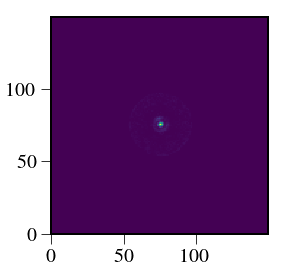

In [58]:
cpfcutoff=1
brightidx = np.array(np.where(pimg*frmt>cpfcutoff)[0])
print brightidx
brightimg = np.zeros(150*150, dtype=np.float)
brightimg[brightidx] = np.random.poisson(pimg[brightidx]*frmt)
plt.imshow(np.reshape(brightimg,(150,150)))

In [62]:
faintidx = np.array(
        np.where((pimg*frmt > 0)*(pimg*frmt <= cpfcutoff))[0])
faintcpf = int(np.round(np.sum(pimg[faintidx])*frmt))
print faintcpf

48


In [128]:
outimg, gainimg, crimg, dkimg, hpimg, phimg = mkemccd(
    '/Users/mrizzo/IFS/OS5_SIM_2.0_noiseless/average/average_target_star_detector.fits',
    frmt=100,
    crrate=5.)

Dark current image
CIC image
Hot pixels image
Cosmic ray image
Photon counts image
Gain image


In [129]:
out = fits.HDUList(fits.PrimaryHDU(outimg.astype(np.float32)))
out.writeto('/Users/mrizzo/Downloads/outimg.fits',overwrite=True)
out = fits.HDUList(fits.PrimaryHDU(crimg.astype(np.float32)))
out.writeto('/Users/mrizzo/Downloads/crimg.fits',overwrite=True)
out = fits.HDUList(fits.PrimaryHDU(phimg.astype(np.float32)))
out.writeto('/Users/mrizzo/Downloads/phimg.fits',overwrite=True)
out = fits.HDUList(fits.PrimaryHDU(dkimg.astype(np.float32)))
out.writeto('/Users/mrizzo/Downloads/dkimg.fits',overwrite=True)
out = fits.HDUList(fits.PrimaryHDU(hpimg.astype(np.float32)))
out.writeto('/Users/mrizzo/Downloads/hpimg.fits',overwrite=True)
# data = fits.getdata('/Users/mrizzo/IFS/OS5_SIM_2.0_noiseless/average/average_target_star_detector.fits')
# out = fits.HDUList(fits.PrimaryHDU(data.astype(np.float32)))
# out.writeto('/Users/mrizzo/Downloads/data.fits')


In [20]:
# xs = 2144
# ys = 1137
xs = 450
ys = 250
analog = np.zeros((ys, xs), dtype=np.float)
phcounting = np.zeros((ys, xs), dtype=np.float)
for i in range(1200):
#     img += mkemccd(
#         '/Users/mrizzo/IFS/OS5_SIM_2.0_noiseless/average/average_target_star_detector.fits',crrate=5.)
    if i%100==0: print(i)
    img = mkemccd(
        '/Users/mrizzo/IFS/mkemccd_v6_171207/speckles_phot_per_second.fits',verbose=False,gain=4000,readn=100,dark=0.5,yrs=4,frmt=72,crrate=5.,HPrate=3.)
#     img = mkemccd(
#         '/Users/mrizzo/IFS/OS5_SIM_2.0_noiseless/average/average_target_star_detector.fits',gain=5000,readn=100,dark=0.5,yrs=2,frmt=72,crrate=5.,HPrate=3.)
    phcounting[img>500] += 1
    analog += img
out = fits.HDUList(fits.PrimaryHDU(analog.astype(np.float32)))
out.writeto('/Users/mrizzo/Downloads/analog.fits',overwrite=True)
out = fits.HDUList(fits.PrimaryHDU(phcounting.astype(np.float32)))
out.writeto('/Users/mrizzo/Downloads/phcounting.fits',overwrite=True)
    

0
100
200
300
400
500
600
700
800
900
1000
1100


In [28]:
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST
data = fits.getdata('/Users/mrizzo/IFS/mkemccd_v6_171207/speckles_phot_per_second.fits')
xs = 450
ys = 250
analog = np.zeros((ys, xs), dtype=np.float)
phcounting = np.zeros((ys, xs), dtype=np.float)

img = readoutWFIRST(
    data,
    tottime=24.*3600.,
    inttime=72.,
    QE=1.0,
    darkBOL=1.4e-4,
    darkEOL=1.4e-4,#2.8e-4,
    CIC=1e-2,
    eff=1.0,
    EMGain=4000.,
    RN=100.0,
    PCbias=0.0,
    crrate=5.0, # per active area per second
    hprate=3.0,
    threshold=5.,
    lifefraction=0.8,
    dqeKnee=1.,#0.858,
    dqeFluxSlope=0.0,
    dqeKneeFlux=0.089,
    xs=xs,
    ys=ys,
    transpose=False,
    returnFullFrame=False,
    nonoise=False,
    poisson=True,
    EMStats=True,
    PCmode=False,
    PCcorrect=False,
    verbose=True)

Number of reads: 1200
227 dark counts per exposure
1125 CIC counts per exposure
14 cosmic rays per exposure
107 hot pixel counts per exposure


In [29]:
fits.writeto('/Users/mrizzo/Downloads/img.fits',img*4000.,overwrite=True)
# out = fits.HDUList(fits.PrimaryHDU(phcounting.astype(np.float32)))
# out.writeto('/Users/mrizzo/Downloads/phcounting.fits',overwrite=True)


In [30]:
fits.writeto('/Users/mrizzo/Downloads/imgmean.fits',np.sum(img,axis=0)*4000.,overwrite=True)


In [17]:
from crispy.tools.detector import mkemccd

img2 = mkemccd(
    '/Users/mrizzo/IFS/mkemccd_v6_171207/speckles_phot_per_second.fits',gain=4000,readn=100,dark=0.5,yrs=4,frmt=100,crrate=5.,HPrate=3.)
out = fits.HDUList(fits.PrimaryHDU(img2.astype(np.float32)))
out.writeto('/Users/mrizzo/Downloads/img2.fits',overwrite=True)
